In [1]:
# load libraries
import nibabel as nib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from ipywidgets import interact
from PIL import Image
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader

In [2]:
if torch.cuda.is_available():
    print("cuda available")    
    device = torch.device("cuda")
else:
    print("not available")
    device = torch.device("cpu")

cuda available


## Some vizualisation functions

In [63]:
def display_slice(slice) :
    return Image.fromarray(np.uint8(slice))

def display_ctscan(sequence) :
    def _show(frame=(0, sequence.shape[2]-1)) :
        return display_slice(sequence[:,:,frame])
    return interact(_show)
def get_images(idx) :
    if idx<10:
        img_vol = nib.load("data/train/volume/LUNG1-00"+str(idx)+"_vol.nii.gz").get_fdata()
        img_seg = nib.load("data/train/seg/LUNG1-00"+str(idx)+"_seg.nii.gz").get_fdata()
    if 10<=idx<100:
        img_vol = nib.load("data/train/volume/LUNG1-0"+str(idx)+"_vol.nii.gz").get_fdata()
        img_seg = nib.load("data/train/seg/LUNG1-0"+str(idx)+"_seg.nii.gz").get_fdata()
    return img_vol, img_seg

In [64]:
img_vol, img_seg = get_images(1)

In [65]:
img_vol = nib.load("data/train/slice_vol/LUNG1-001_vol_slice_70.nii.gz").get_fdata()
img_seg = nib.load("data/train/slice_seg/LUNG1-001_seg_slice_70.nii.gz").get_fdata()

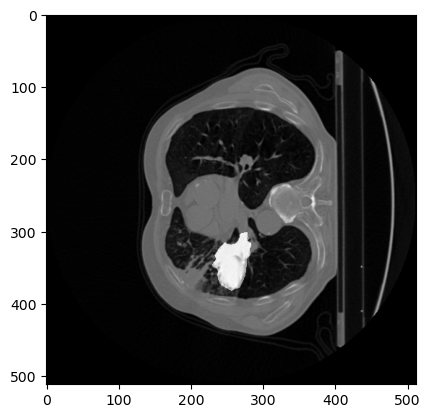

In [66]:
plt.imshow(img_vol+np.max(img_vol)*img_seg, cmap="gray")

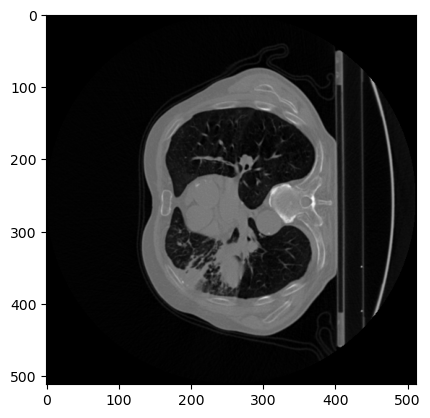

In [7]:
plt.imshow(img_vol, cmap="gray")

In [8]:
def display(img_vol, img_seg) :
    k, l, m = img_vol.shape
    img = np.zeros((k, 2*l, m))
    v_max = np.max(img_vol)
    img[:,:l,:] = v_max*img_seg
    img[:,l:,:] = img_vol
    display_ctscan(img)

In [9]:
print(np.shape(img_vol))

(512, 512)


In [10]:
def extract_slices(volume_data, slice_size):
    slices = []
    depth = volume_data.shape[2]

    for i in range(0, depth):
        slice_2d = volume_data[:, :, i]
        slices.append(slice_2d)

    return slices

In [11]:
#os.mkdir("data/train/slice_vol")
#os.mkdir("data/train/slice_seg")

In [12]:
files = os.listdir("data/train/volume/")
files.sort()

In [13]:
files = os.listdir("data/train/seg/")
files.sort()

In [14]:
dataset_dir = "data/train/volume/"
output_dir = "data/train/slice_vol/"

for filename in files:
    c = 0
    if filename.endswith('.nii.gz'):
        file_path = os.path.join(dataset_dir, filename)

        img = nib.load(file_path)
        volume_data = img.get_fdata()
        _, _, h = volume_data.shape
    
        for i in range(h):
            output_filename = f"{filename.split('.')[0]}_slice_{c + 1}.nii.gz"
            output_path = os.path.join(output_dir, output_filename)
            c+=1
            new_img = nib.Nifti1Image(volume_data[:,:,i], img.affine)

            nib.save(new_img, output_path)

FileNotFoundError: No such file or no access: 'data/train/volume/LUNG1-001_seg.nii.gz'

In [51]:
dataset_dir = "data/train/seg/"
output_dir = "data/train/slice_seg//"

for filename in files:
    c = 0
    if filename.endswith('.nii.gz'):
        file_path = os.path.join(dataset_dir, filename)

        img = nib.load(file_path)
        volume_data = img.get_fdata()
        _, _, h = volume_data.shape
    
        for i in range(h):
            output_filename = f"{filename.split('.')[0]}_slice_{c + 1}.nii.gz"
            output_path = os.path.join(output_dir, output_filename)
            c+=1
            new_img = nib.Nifti1Image(volume_data[:,:,i], img.affine)

            nib.save(new_img, output_path)

## Dataset

In [15]:
class IPPMedDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        vol_dir = os.path.join(root_dir, 'slice_vol')
        self.vol_paths = [os.path.join(vol_dir, vol_path) for vol_path in os.listdir(vol_dir)]        
        seg_dir = os.path.join(root_dir, 'slice_seg')
        self.seg_paths = [os.path.join(seg_dir, seg_path) for seg_path in os.listdir(seg_dir)]        
        self.vol_paths.sort()
        self.seg_paths.sort()
        self.transform = transform
        
    def __len__(self):
        return len(self.vol_paths)

    def __getitem__(self, idx):
        vol_path = self.vol_paths[idx]
        seg_path = self.seg_paths[idx]
        vol_img= nib.load(vol_path).get_fdata()
        seg_img = nib.load(seg_path).get_fdata()

        if self.transform:
            vol_img = self.transform(vol_img)
            seg_img = self.transform(seg_img)

        return torch.from_numpy(vol_img).to(torch.float32).unsqueeze(0), \
               torch.from_numpy(seg_img).to(torch.float32).unsqueeze(0)

In [16]:
class TestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        vol_dir = os.path.join(root_dir, 'volume')
        self.vol_paths = [os.path.join(vol_dir, vol_path) for vol_path in os.listdir(vol_dir)]        
        self.vol_paths.sort()
        self.transform = transform
        
    def __len__(self):
        return len(self.vol_paths)

    def __getitem__(self, idx):
        vol_path = self.vol_paths[idx]
        vol_img= nib.load(vol_path).get_fdata()

        if self.transform:
            vol_img = self.transform(vol_img)

        return vol_img

In [13]:
batch_size=5
data_root = "data/train/"
ippmed_dataset = IPPMedDataset(data_root, transform=None)
data_train_loader = DataLoader(dataset=ippmed_dataset, batch_size=batch_size, shuffle=True) 

In [14]:
batch_size=1
test_root = "data/test"
test_dataset = TestDataset(test_root, transform=transform)
print(len(test_dataset))
data_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False) 

NameError: name 'transform' is not defined

In [15]:
img_vol, img_seg = next(iter(data_train_loader))

In [16]:
img_vol = next(iter(data_loader))

NameError: name 'data_loader' is not defined

In [17]:
img_vol.shape

torch.Size([5, 1, 512, 512])

## ToDo

- DataSet : done
- Losses
- First model
- Train loop, save model
- Prediction

## Definition of the losses

In [3]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        inputs = torch.sigmoid(inputs)

        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice

class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        inputs = torch.sigmoid(inputs)

        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE

## The model

In [4]:
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)

        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)

        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x

class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)

        return x, p

class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)

    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x

class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        """ Encoder """
        self.e1 = encoder_block(1, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)

        """ Bottleneck """
        self.b = conv_block(512, 1024)

        """ Decoder """
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)

        """ Classifier """
        self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0)

    def forward(self, inputs):
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        """ Bottleneck """
        b = self.b(p4)

        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        outputs = self.outputs(d4)

        return outputs

In [51]:
in_channels = 1  # single-channel input
out_channels = 1  # Number of segmentation classes
model = UNet().to(device)

#print(model)

In [5]:
model = UNet()
model = model.to(device)
model.load_state_dict(torch.load("checkpoint.pth", map_location=device))

<All keys matched successfully>

In [ ]:
img_vol, img_seg = 

In [21]:
img_vol, img_seg = next(iter(data_train_loader))

In [22]:
len(data_train_loader)

6989

In [25]:
from time import time

In [26]:
start = time()
test = model(img_vol.to(device))
end = time()

In [61]:
img_v = nib.load("data/train/volume/LUNG1-002_vol.nii.gz").get_fdata()
img_s = nib.load("data/train/seg/LUNG1-002_seg.nii.gz").get_fdata()

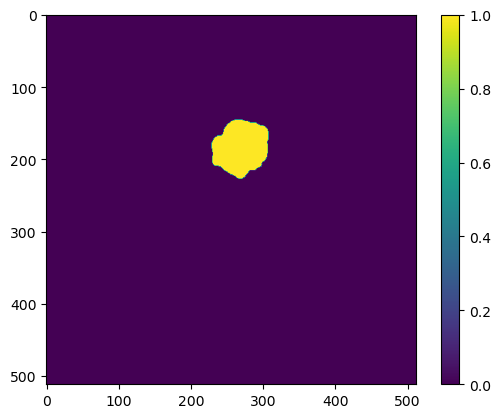

In [76]:
plt.imshow(img_s[:,:,45]>0)
plt.colorbar()
plt.show()

In [67]:
img_vol = torch.from_numpy(img_v).to(torch.float32).unsqueeze(0).to(device)
img_seg = torch.from_numpy(img_s).to(torch.float32).unsqueeze(0).to(device)

In [71]:
img_vol = img_vol[:,:,:,:].unsqueeze(0)
img_vol.shape

torch.Size([1, 1, 512, 512, 111])

In [56]:
pred = torch.zeros((1, 512, 512, 134))

In [77]:
test = img_vol[:,:,:,:,45]
test.shape

torch.Size([1, 1, 512, 512])

In [78]:
pred = model(test)

In [ ]:
def pred(img) :
    _, _, _, w = img.shape
    for i in range(w) :
        pred = model(img[:,:,])
        pred = 
        preds.app

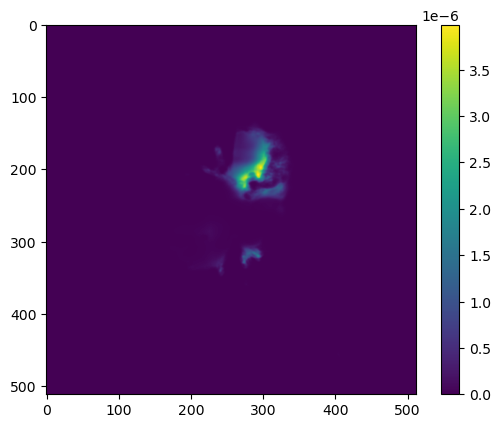

In [79]:
plt.imshow(torch.sigmoid(pred).squeeze(0, 1).cpu().detach().numpy())
plt.colorbar()
plt.show()

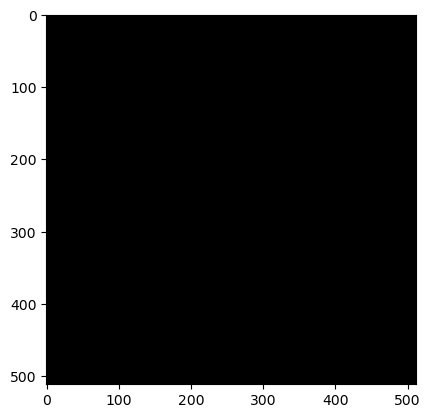

In [40]:
plt.imshow(test[1,0,:,:].cpu().softmax(0).detach().numpy()>0.5, cmap="gray")
plt.show()

In [29]:
plt.imshow(torch.softmax(test[0,0,:,:]).cpu().detach().numpy(), cmap="gray")

TypeError: softmax() received an invalid combination of arguments - got (Tensor), but expected one of:
 * (Tensor input, int dim, torch.dtype dtype, *, Tensor out)
 * (Tensor input, name dim, *, torch.dtype dtype)


In [69]:
def train(model, loader, optimizer, loss_fn, device):
    epoch_loss = 0.0

    model.train()
    k=0
    for x, y in loader:
        x = x.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.float32)

        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        k+=1
        if k>2 :
            break

    epoch_loss = epoch_loss/len(loader)
    return epoch_loss

In [28]:
batch_size = 1
num_epochs = 60
lr = 1e-4
#checkpoint_path = "files/checkpoint3.pth"

In [70]:
device = torch.device('cuda')   ## GTX 1060 6GB
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)
loss_fn = DiceBCELoss() #nn.CrossEntropyLoss(reduction="mean") #DiceBCELoss()
losses=[]

In [85]:
start = time()
for epoch in range(1):

    train_loss = train(model, data_train_loader, optimizer, loss_fn, device)
    losses.append((train_loss))

end = time()
print(losses)

[0.0004371827142333111, 0.00043724219095282225, 0.00043689155633194727, 0.0004367983926261916, 0.00043651274403954017]


In [84]:
(end-start)/15

0.14653353691101073